In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from statistics import mean
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 144, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [14]:
# Partition training, dev, and test data
allStats = pd.read_csv('../allStats.csv').dropna(subset=['fanPts'])
X = allStats \
    .loc[:,allStats.columns.str.contains('-\d+') | allStats.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = allStats.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### Multi-layer Perceptron Regression

#### Base model

99 iterations
3 layers


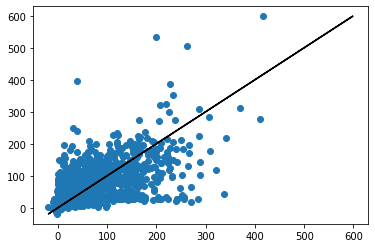

MAE: 33.7
RMSE: 50.9
R^2: 0.36


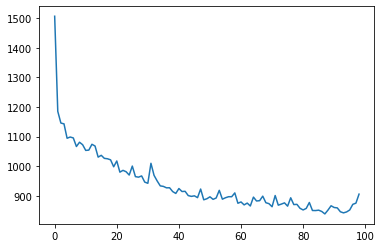

In [17]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = neural_network.MLPRegressor(max_iter=1000)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)

#### GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
    inputNodes*2-1
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(2,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0,max_iter=1000),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1000 iterations
3 layers


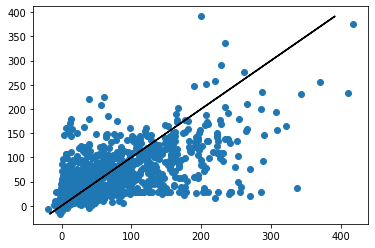

MAE: 31.8
RMSE: 47.4
R^2: 0.45


AttributeError: 'MLPRegressor' object has no attribute 'loss_curve_'

In [9]:
tempParams = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 8, 'solver': 'lbfgs'}
m = neural_network.MLPRegressor(**tempParams,max_iter=1000)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)
plt.show()

cvGrid(params).to_csv('nnRaw.csv')

#### GridSearchCV, standardized

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
    inputNodes*2-1
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(2,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0,max_iter=1000),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

965 iterations
3 layers


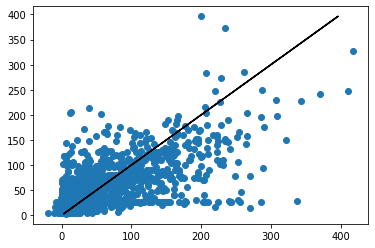

MAE: 31.3
RMSE: 46.7
R^2: 0.46


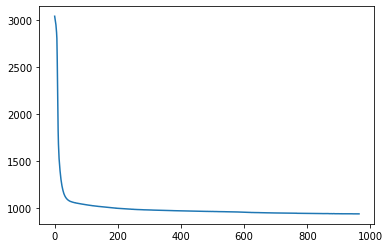

In [18]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev
tempParams = {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 4, 'solver': 'adam'}

m = neural_network.MLPRegressor(**tempParams,max_iter=1000)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)
plt.show()

cvGrid(params).to_csv('nnStd.csv')

#### GridSearchCV, standardized, hand-selected features

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
    inputNodes*2-1
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(2,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0,max_iter=1000),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

967 iterations
3 layers


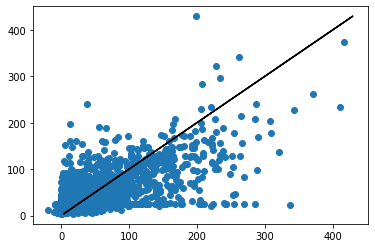

MAE: 31.2
RMSE: 46.7
R^2: 0.46


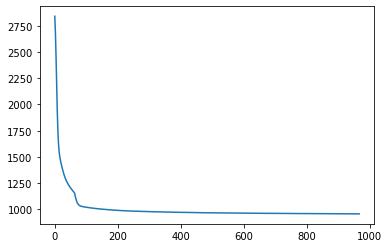

In [19]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev
tempParams = {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 4, 'solver': 'adam'}

m = neural_network.MLPRegressor(**tempParams,max_iter=1000)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)
plt.show()

cvGrid(params).to_csv('nnSelect.csv')